$\newcommand{\myvector}[2]{\left\{ \begin{array}{c}#1\\#2\end{array} \right\}}$
$\newcommand{\sM}[1]{s_{\mathrm{M#1}}}$
$\newcommand{\xM}[1]{x_{\mathrm{M#1}}}$
$\newcommand{\xpM}[1]{x'_{\mathrm{M#1}}}$

# APPENDIX B:  Bayesian vs. least-squares estimates of population means


This Appendix describes two Bayesian approaches to population mean estimation and then compares results to the least-squares solution (i.e. the sample mean). Let's start by drawing a random sample from the standard normal distribution, for which the true population mean and standard deviation (SD) are 0 and 1, respectively:

In [1]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot
import pymc

np.random.seed(4)        #arbitrarily set the random number generator seed
J = 5                    #sample size
y = np.random.randn(J)   #random data sample
print('A random sample from the standard normal distribution:')
print('   (True population mean = 0)')
print('   (True population SD   = 1)')   #standard deviation (SD)
print(y)

A random sample from the standard normal distribution:
   (True population mean = 0)
   (True population SD   = 1)
[ 0.05056171  0.49995133 -0.99590893  0.69359851 -0.41830152]


## Approach 1: Least-squares

The least squares (LS) solution minimizes the following function:

\begin{equation}
f(x)  = \sum (x - y_i)^2
\end{equation}

where $x$ is the estimate of the population mean, and $y_i$ are the individual sample observations. The value of $x$ which minimizes $f(x)$ is the sample mean:


In [2]:
mean_ls = np.mean( y )  #optimum value for "x" in the equation above
print('Least-squares estimate of the population mean (i.e. sample mean):')
print( mean_ls )

Least-squares estimate of the population mean (i.e. sample mean):
-0.0340197804923


Note that the sample mean is not zero, even through the true population mean is zero.  For the sample mean to converge precisely to the population mean, one would generally have to draw an infinitely large sample, or sample the entire population.

## Approach 2: Bayesian (known variance)

The simplest Bayesian approach is to presume that population SD ($\sigma$) is known. Let's implement the full solution in PyMC, then consider the commands afterwards.

In [3]:
#(1) Build model
x          = pymc.Uniform("x", -3, 3)  #prior distribution for the population mean
sigma      = 1                         #known population standard deviation (SD)
tau        = 1.0 / sigma**2            #measurement precision ( 1 / SD^2 )
data_model = pymc.Normal("data_model", x, tau, observed=True, value=y)  #model of the observations

#(2) Conduct inference:
model = pymc.Model([data_model, x])    #full model containing data model and all stochastic variables
mcmc  = pymc.MCMC(model)               #MCMC sampler
mcmc.sample(iter=11000, burn=1000)     #MC sampling
post  = mcmc.trace("x")[:]             #posterior distribution for the population mean
bmean = post.mean()                    #Bayesian estimate of the population mean
print()
print('Bayesian estimate of the population mean (known variance):')
print(bmean)

 [-----------------100%-----------------] 11000 of 11000 complete in 0.4 sec
Bayesian estimate of the population mean (known variance):
-0.0292631259209


Note that the Bayesian estimate of the population mean is closer to its true value of zero.

In order to conduct Bayesian inference regarding experimental data, a model of those data is required. The first step is to create a prior distribution for each stochastic variable:

In [4]:
x          = pymc.Uniform("x", -3, 3)  #naive prior distribution for the population mean

This prior implies that we expect the true population mean to be between -1 and +1, and that all values in this range are equally likely. As described in Appendix A, the prior can affect the final results, and we shall consider effects of priors below.

The next step is to build a model of the data:

In [5]:
data_model = pymc.Normal("data_model", x, tau, observed=True, value=y)  #model of the observations

This command implies that we believe that our data sample comes from a normal distribution with an unknown population mean of x and a known precision of tau=1. The "observed=True" and "value=y" keyword arguments specify that the values in y were observed. In other words, based on the values y we want to find the most likely value for x, or more generally the posterior distribution for x given y.

Now that we have the model we can conduct inference, and the MCMC-related inference commands above follow from Appendix A so are not discussed further here. Following inference, it can be informative to visualize the prior and the posterior distributions:

<IPython.core.display.Javascript object>


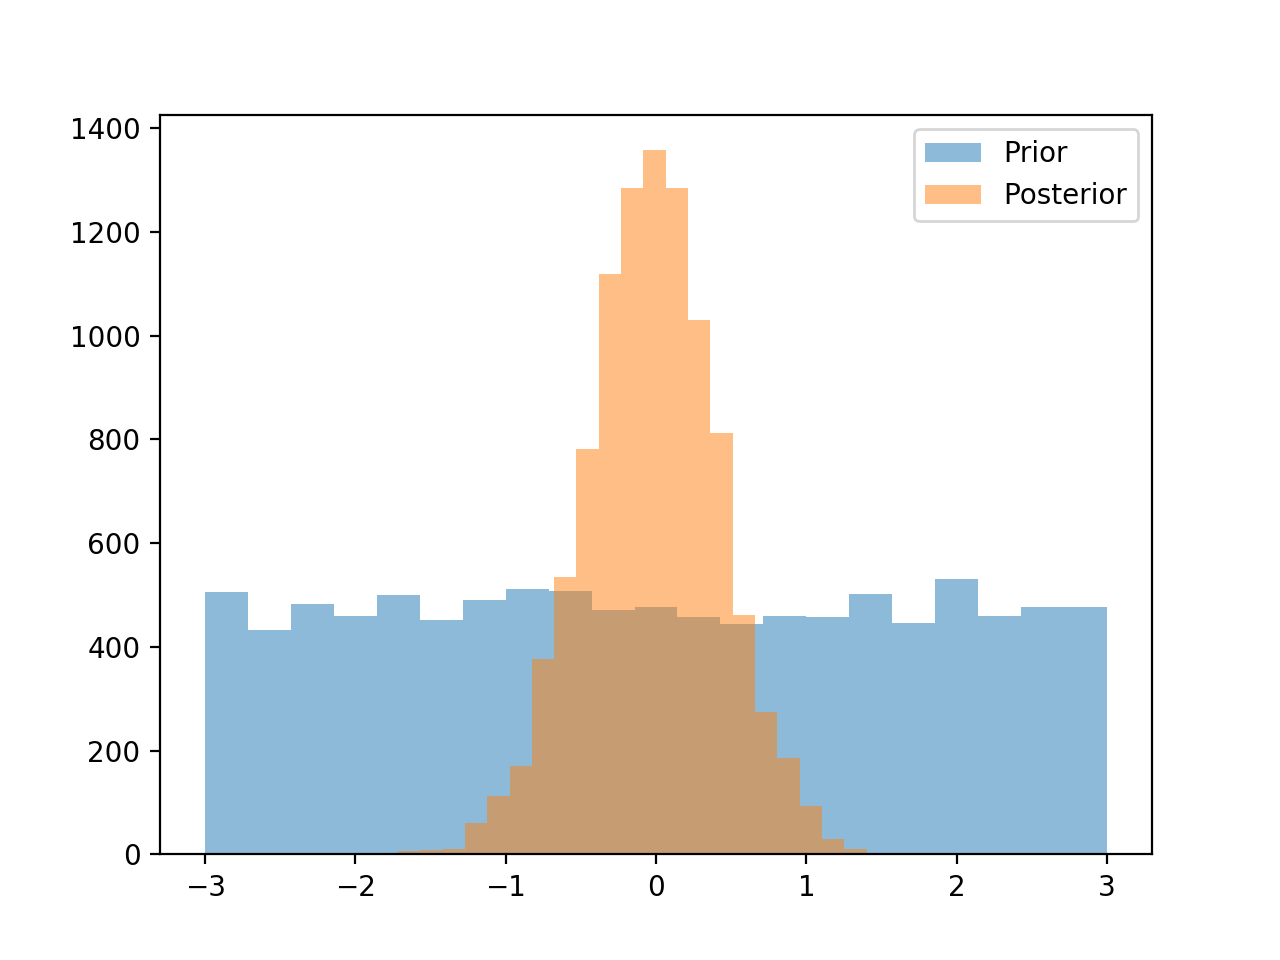

In [6]:
prior   = [x.random() for i in range(10000)]

pyplot.figure()
ax = pyplot.axes()
ax.hist(prior, bins=21, alpha=0.5, label='Prior')      #prior distribution for x
ax.hist(post,  bins=21, alpha=0.5, label='Posterior')  #posterior distribution for x
ax.legend();

The observed data sample y has changed our beliefs regarding x from the depicted prior distribution into the depicted posterior distribution via Bayes' rule.



## Approach 3: Bayesian (unknown variance)

In order to model unknown variance we just need to change the precision variable (tau) into a stochastic variable, then ensure that tau is included int the full pymc model like this: 

In [7]:
#(1) Build model
x          = pymc.Uniform("x", -3, 3)       #prior distribution for the population mean
tau        = pymc.Uniform("tau", 0.01, 100) #prior distribution for precision
data_model = pymc.Normal("data_model", x, tau, observed=True, value=y)  #model of the observations

#(2) Conduct inference:
model = pymc.Model([data_model, x, tau])   #full model containing data model and all stochastic variables
mcmc  = pymc.MCMC(model)               #MCMC sampler
mcmc.sample(iter=11000, burn=1000)     #MC sampling
post  = mcmc.trace("x")[:]             #posterior distribution for the population mean
bmean = post.mean()                    #Bayesian estimate of the population mean
print()
print('Bayesian estimate of the population mean (unknown variance):')
print(bmean)

 [-----------------100%-----------------] 11000 of 11000 complete in 0.7 sec
Bayesian estimate of the population mean (unknown variance):
-0.028969135243


Adding tau as a stochastic variable has not greatly affected the results.

## Systematic comparison between Bayesian and LS approaches

The analyses above represent a single dataset, single sample size, and single prior distributions, and results showed that the Bayesian results were somewhat more accurate. How do Bayesian and LS approaches compare for arbitrary datasets, sample sizes, priors, etc.?  To answer that question comprehenively would require millions of simulations. Here we shall consider only effects of dataset, and we'll check whether Bayesian or LS approaches perform better.

In [8]:
#create a function for estimating population mean using Bayesian inference:
def bayesian_mean(y, iter=11000, burn=1000):
    #build model:
    x       = pymc.Uniform("x", -3, 3)
    tau     = pymc.Uniform("tau", 0.01, 100)
    dmodel  = pymc.Normal("data_model", x, tau, observed=True, value=y)
    #conduct inference:
    model   = pymc.Model([data_model, x])
    mcmc    = pymc.MCMC(model)           
    mcmc.sample(iter=iter, burn=burn, progress_bar=False)
    post    = mcmc.trace("x")[:]
    return post.mean()


np.random.seed(0)
nDatasets   = 20   #number of datasets to generate
n           = 0    #number of datasets for which the Bayesian estimate is more accurate
for i in range(nDatasets):
    y       = np.random.randn(J)
    mean_ls = y.mean()
    mean_b  = bayesian_mean(y, iter=110000, burn=10000)
    if (abs(mean_ls) < abs(mean_b)):
        result = 'LS'
    else:
        result = 'Bayesian'
        n     += 1
    print('Dataset %d.  LS: %.5f, Bayesian: %.5f (%s more accurate)' %(i, mean_ls, mean_b, result))
print()
print('Bayesian more accurate in %d/%d datasets.' %(n,nDatasets))

Dataset 0.  LS: 1.45028, Bayesian: 1.44847 (Bayesian more accurate)
Dataset 1.  LS: 0.15133, Bayesian: 0.15841 (LS more accurate)
Dataset 2.  LS: -0.72543, Bayesian: -0.72868 (LS more accurate)
Dataset 3.  LS: -0.22593, Bayesian: -0.22542 (Bayesian more accurate)
Dataset 4.  LS: -0.11956, Bayesian: -0.11465 (Bayesian more accurate)
Dataset 5.  LS: 1.47015, Bayesian: 1.46882 (Bayesian more accurate)
Dataset 6.  LS: -0.80645, Bayesian: -0.80766 (LS more accurate)
Dataset 7.  LS: -0.40028, Bayesian: -0.39992 (Bayesian more accurate)
Dataset 8.  LS: 0.22548, Bayesian: 0.22538 (Bayesian more accurate)
Dataset 9.  LS: -0.56589, Bayesian: -0.56771 (LS more accurate)
Dataset 10.  LS: 0.00039, Bayesian: 0.00468 (LS more accurate)
Dataset 11.  LS: 0.21691, Bayesian: 0.21854 (LS more accurate)
Dataset 12.  LS: -0.14829, Bayesian: -0.14565 (Bayesian more accurate)
Dataset 13.  LS: -0.18566, Bayesian: -0.18351 (Bayesian more accurate)
Dataset 14.  LS: -0.41073, Bayesian: -0.41028 (Bayesian more acc

We can see that the Bayesian approach is occasionally, but not compellingly more accurate than the LS approach.

## Summary

This Appendix has shown that population means can be estimated not only using the typical LS approach (i.e. the sample mean), but also using at least two different Bayesian approaches. Results show that Bayesian estimates are slightly more accurate than LS estimates for some datasets, but overall that there is not much difference. However, this is a very simple case of Bayesian inference, with a very simple data model. Subsequent Appendices and the main paper show that Bayesian and LS accuracies diverge as the data model becomes more complex.